In [14]:
import re
import nltk
import spacy
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

In [3]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91991\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91991\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
stop_words = nltk.corpus.stopwords.words('english')


### Data Loading

In [5]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


### Simple Text Pre-processing

In [6]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

### Bag of Words Model - TF

In [9]:
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]],
      dtype=int64)

In [10]:
# get all unique words in the corpus
vocab = cv.get_feature_names()

# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


### Bag of N-Grams Model

In [14]:
# you can set the n-gram range to 1,3 to get unigrams, bigrams and trigrams
bv = CountVectorizer(ngram_range=(1,3))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,bacon,bacon eggs,bacon eggs toast,beans,beautiful,beautiful sky,beautiful today,blue,blue beautiful,blue beautiful sky,...,sausages ham bacon,sky,sky beautiful,sky beautiful today,sky blue,sky blue beautiful,sky blue sky,toast,toast beans,today
0,0,0,0,0,1,0,0,1,1,0,...,0,1,0,0,1,1,0,0,0,0
1,0,0,0,0,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,1,1,0,0,...,0,2,1,1,1,0,1,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF Model

In [16]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, ngram_range=(1,3))
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,bacon,bacon eggs,bacon eggs toast,beans,beautiful,beautiful sky,beautiful today,blue,blue beautiful,blue beautiful sky,...,sausages ham bacon,sky,sky beautiful,sky beautiful today,sky blue,sky blue beautiful,sky blue sky,toast,toast beans,today
0,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.32,0.43,0.00,...,0.00,0.37,0.00,0.00,0.43,0.51,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.28,0.38,0.00,0.24,0.32,0.38,...,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.19,0.22,0.22,0.22,0.00,0.00,0.00,0.00,0.00,0.00,...,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.22,0.00
4,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.22,0.00,0.31,0.19,0.00,0.00,...,0.00,0.44,0.31,0.31,0.26,0.00,0.31,0.00,0.00,0.31
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Robust Word2Vec Model with Gensim

In [7]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


In [8]:
tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_corpus]

# Set values for various parameters
feature_size = 15    # Word vector dimensionality  
window_context = 20  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              size=feature_size, 
                              window=window_context, 
                              min_count = min_word_count,
                              sg=sg, 
                              sample=sample, 
                              iter=5000)
w2v_model

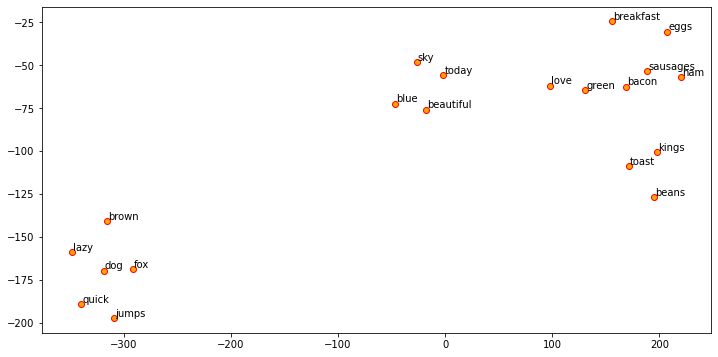

In [11]:
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12,6))
plt.scatter(T[:, 0], T[:, 1], 
            c='orange',
           edgecolors='r')

for label, x, y in zip(labels, T[:,0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1),
                xytext=(0, 0),
                textcoords='offset points')

In [12]:
w2v_model.wv['sky'], w2v_model.wv['sky'].shape

(array([-0.29653928, -0.39441594, -0.03985346,  0.6552125 ,  1.3204838 ,
        -0.25330293,  0.24795002,  0.60584605,  0.81810874,  0.39632902,
         0.86200863,  1.5677558 ,  0.37940276, -0.49400005,  0.02332627],
       dtype=float32),
 (15,))

In [14]:
vec_df = pd.DataFrame(wvs, index=words)
vec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sky,-0.296539,-0.394416,-0.039853,0.655213,1.320484,-0.253303,0.247950,0.605846,0.818109,0.396329,0.862009,1.567756,0.379403,-0.494000,0.023326
blue,-0.224718,-0.567977,-0.187922,0.247713,0.898845,-0.226592,-0.119430,0.041420,0.505140,0.320020,0.592017,1.174921,-0.151006,-0.427213,0.190858
beautiful,-0.270976,-0.277305,-0.027322,0.599076,1.209581,-0.146922,0.193528,0.597515,0.653745,0.222624,0.843796,1.468316,0.370110,-0.491219,0.069768
quick,-0.688111,-0.564932,-0.491267,-1.042961,0.917170,0.216122,-0.335897,-0.101818,0.552838,0.871012,-0.180729,1.085848,-0.282139,0.162618,1.000159
brown,-0.819171,-0.524280,-0.424934,-0.891199,1.053275,0.068582,-0.622322,-0.322044,0.687788,0.754539,-0.370032,1.013097,-0.512937,-0.047153,0.881843
fox,-0.590573,-0.716470,-0.439961,-1.033523,0.981327,-0.011228,-0.316907,-0.145375,0.616713,0.700961,-0.445265,1.240694,-0.200606,0.235317,1.027019
lazy,-0.658394,-0.428919,-0.186661,-0.976144,0.901890,0.310448,-0.566777,-0.101285,0.626006,0.866012,-0.391076,1.129571,-0.164206,0.303199,1.140745
dog,-0.640750,-0.772845,-0.588552,-0.915436,1.012125,0.109694,-0.306180,-0.013123,0.407980,0.634795,-0.477381,1.121771,-0.390263,0.077831,1.014197
love,-0.203201,0.407931,-0.435212,0.404638,0.282662,-0.142093,0.171688,0.582321,0.557950,-0.113123,0.153471,0.736643,0.782782,-0.389288,-0.174639
sausages,-0.829622,1.118903,-1.092630,-0.007085,0.199861,-0.306694,-0.285967,0.518775,0.418778,-0.297591,0.048084,0.544595,0.918423,-0.268899,0.019217


#### Term semantic similarity

In [17]:
similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df

,sky,blue,beautiful,quick,brown,fox,lazy,dog,love,sausages,ham,bacon,eggs,jumps,kings,breakfast,toast,beans,green,today
sky,1.000000,0.915538,0.995558,0.427627,0.409796,0.434607,0.388025,0.420011,0.710918,0.332196,0.349841,0.323812,0.326127,0.316899,0.190128,0.139325,0.155682,0.167370,0.463673,0.990372
blue,0.915538,1.000000,0.904252,0.615443,0.633130,0.620177,0.556692,0.621228,0.475727,0.190307,0.257143,0.200746,0.188970,0.546761,0.101052,0.046933,0.063629,0.087788,0.330453,0.893736
beautiful,0.995558,0.904252,1.000000,0.406490,0.385859,0.410347,0.370059,0.400342,0.726294,0.358618,0.383720,0.349019,0.352421,0.294576,0.212915,0.163291,0.179454,0.189730,0.498538,0.986884
quick,0.427627,0.615443,0.406490,1.000000,0.969991,0.983284,0.979013,0.978185,0.079890,0.158683,0.106443,0.168336,0.130392,0.981641,0.215437,0.258715,0.235921,0.232503,0.108289,0.398887
brown,0.409796,0.633130,0.385859,0.969991,1.000000,0.963020,0.957855,0.963844,0.051590,0.156535,0.135365,0.173058,0.135776,0.983956,0.207916,0.249712,0.222412,0.224508,0.089551,0.379355
fox,0.434607,0.620177,0.410347,0.983284,0.963020,1.000000,0.971766,0.985736,0.097337,0.145509,0.090148,0.139875,0.134589,0.975362,0.209952,0.226894,0.221587,0.214054,0.071290,0.419361
lazy,0.388025,0.556692,0.370059,0.979013,0.957855,0.971766,1.000000,0.952568,0.064341,0.146023,0.087283,0.145773,0.133946,0.969958,0.203575,0.261990,0.228429,0.219478,0.047965,0.371824
dog,0.420011,0.621228,0.400342,0.978185,0.963844,0.985736,0.952568,1.000000,0.072708,0.134102,0.089984,0.136506,0.107534,0.972011,0.197493,0.210116,0.213526,0.201026,0.081551,0.401154
love,0.710918,0.475727,0.726294,0.079890,0.051590,0.097337,0.064341,0.072708,1.000000,0.792148,0.734806,0.736124,0.794653,0.008229,0.670898,0.595267,0.625428,0.637880,0.805895,0.742319
sausages,0.332196,0.190307,0.358618,0.158683,0.156535,0.145509,0.146023,0.134102,0.792148,1.000000,0.952858,0.981934,0.967055,0.163422,0.966470,0.941818,0.954913,0.963129,0.922213,0.333472


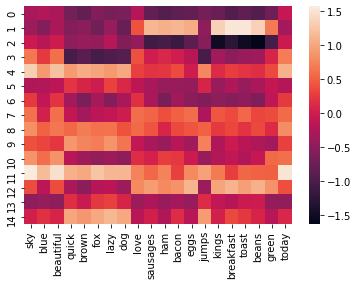

In [29]:
ax = sns.heatmap(vec_df.transpose(), )

In [30]:
feature_names = np.array(words)
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]],
                    axis=1)

sky              [beautiful, today, blue]
blue              [sky, beautiful, today]
beautiful              [sky, today, blue]
quick                  [fox, jumps, lazy]
brown                 [jumps, quick, dog]
fox                   [dog, quick, jumps]
lazy                  [quick, fox, jumps]
dog                   [fox, quick, jumps]
love              [green, eggs, sausages]
sausages             [bacon, eggs, kings]
ham               [sausages, eggs, bacon]
bacon        [sausages, beans, breakfast]
eggs               [sausages, ham, kings]
jumps                 [brown, quick, fox]
kings            [toast, beans, sausages]
breakfast           [toast, beans, kings]
toast           [kings, beans, breakfast]
beans           [kings, toast, breakfast]
green              [ham, bacon, sausages]
today              [sky, beautiful, blue]
dtype: object

### Robust Glove Model with SpaCy

In [42]:
nlp_lg = spacy.load('en_core_web_lg')

In [45]:
total_vectors = len(nlp_lg.vocab.vectors)

In [46]:
total_vectors

684830

In [52]:
unique_words = list(set([word for sublist in tokenized_corpus for word in sublist]))

word_glove_vectors = np.array([nlp_lg(word).vector for word in unique_words])
vec_df = pd.DataFrame(word_glove_vectors, index=unique_words)
vec_df


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
sausages,-0.174290,-0.064869,-0.046976,0.287420,-0.128150,0.647630,0.056315,-0.240440,-0.025094,0.50222,...,0.302240,0.195470,-0.653980,-0.291150,-0.684290,-0.266370,0.304310,-0.806830,0.619540,0.201200
fox,-0.348680,-0.077720,0.177750,-0.094953,-0.452890,0.237790,0.209440,0.037886,0.035064,0.89901,...,-0.283050,0.270240,-0.654800,0.105300,-0.068738,-0.534750,0.061783,0.123610,-0.553700,-0.544790
toast,0.130740,-0.193730,0.253270,0.090102,-0.272580,-0.030571,0.096945,-0.115060,0.484000,0.84838,...,0.142080,0.481910,0.045167,0.057151,-0.149520,-0.495130,-0.086677,-0.569040,-0.359290,0.097443
brown,-0.374120,-0.076264,0.109260,0.186620,0.029943,0.182700,-0.631980,0.133060,-0.128980,0.60343,...,-0.015404,0.392890,-0.034826,-0.720300,-0.365320,0.740510,0.108390,-0.365760,-0.288190,0.114630
jumps,-0.334840,0.215990,-0.350440,-0.260020,0.411070,0.154010,-0.386110,0.206380,0.386700,1.46050,...,-0.107030,-0.279480,-0.186200,-0.543140,-0.479980,-0.284680,0.036022,0.190290,0.692290,-0.071501
ham,-0.773320,-0.282540,0.580760,0.841480,0.258540,0.585210,-0.021890,-0.463680,0.139070,0.65872,...,0.464470,0.481400,-0.829200,0.354910,0.224530,-0.493920,0.456930,-0.649100,-0.131930,0.372040
lazy,-0.353320,-0.299710,-0.176230,-0.321940,-0.385640,0.586110,0.411160,-0.418680,0.073093,1.48650,...,0.402310,-0.038554,-0.288670,-0.244130,0.460990,0.514170,0.136260,0.344190,-0.845300,-0.077383
green,-0.072368,0.233200,0.137260,-0.156630,0.248440,0.349870,-0.241700,-0.091426,-0.530150,1.34130,...,-0.405170,0.243570,0.437300,-0.461520,-0.352710,0.336250,0.069899,-0.111550,0.532930,0.712680
breakfast,0.073378,0.227670,0.208420,-0.456790,-0.078219,0.601960,-0.024494,-0.467980,0.054627,2.28370,...,0.647710,0.373820,0.019931,-0.033672,-0.073184,0.296830,0.340420,-0.599390,-0.061114,0.232200
dog,-0.401760,0.370570,0.021281,-0.341250,0.049538,0.294400,-0.173760,-0.279820,0.067622,2.16930,...,0.022908,-0.259290,-0.308620,0.001754,-0.189620,0.547890,0.311940,0.246930,0.299290,-0.074861


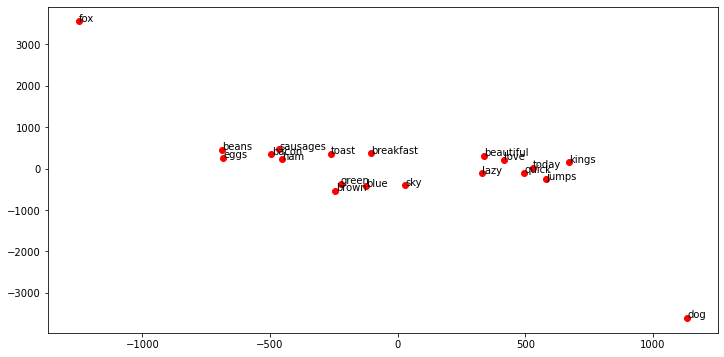

In [53]:
tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)

T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='red', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Term Semantic Similarity

In [54]:
similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=unique_words, columns=unique_words)
similarity_df

,sausages,fox,toast,brown,jumps,ham,lazy,green,breakfast,dog,sky,bacon,beans,blue,kings,eggs,beautiful,love,quick,today
sausages,1.000000,0.133348,0.498062,0.289625,0.083306,0.622770,0.168205,0.233169,0.415231,0.247529,0.061753,0.729162,0.546647,0.097443,0.070071,0.548311,0.114540,0.146917,0.162966,0.094879
fox,0.133348,1.000000,0.163371,0.406911,0.250834,0.209454,0.267240,0.323800,0.165064,0.485855,0.303459,0.210082,0.118537,0.371178,0.226735,0.247314,0.210050,0.255050,0.192686,0.150072
toast,0.498062,0.163371,1.000000,0.347578,0.119099,0.500586,0.231329,0.287608,0.513436,0.182994,0.216372,0.622701,0.449284,0.232264,0.125741,0.495935,0.189482,0.274246,0.292624,0.174257
brown,0.289625,0.406911,0.347578,1.000000,0.110400,0.335111,0.256875,0.646850,0.277158,0.341204,0.408844,0.432891,0.453427,0.683011,0.193487,0.466903,0.355701,0.331943,0.217009,0.147418
jumps,0.083306,0.250834,0.119099,0.110400,1.000000,0.046432,0.222112,0.150752,0.103865,0.307961,0.278595,0.091021,0.095544,0.187263,0.086659,0.150622,0.142554,0.185114,0.301096,0.142099
ham,0.622770,0.209454,0.500586,0.335111,0.046432,1.000000,0.222571,0.290761,0.371687,0.262579,0.174496,0.738816,0.495773,0.185452,0.127651,0.489116,0.110936,0.218128,0.191665,0.104115
lazy,0.168205,0.267240,0.231329,0.256875,0.222112,0.222571,1.000000,0.230945,0.319941,0.301678,0.259361,0.264376,0.245672,0.230513,0.190515,0.236769,0.294308,0.339280,0.400060,0.286802
green,0.233169,0.323800,0.287608,0.646850,0.150752,0.290761,0.230945,1.000000,0.288437,0.272693,0.488385,0.386664,0.462498,0.764083,0.151519,0.392072,0.392392,0.327302,0.287504,0.246754
breakfast,0.415231,0.165064,0.513436,0.277158,0.103865,0.371687,0.319941,0.288437,1.000000,0.295957,0.205429,0.487737,0.378215,0.197103,0.161840,0.431108,0.314472,0.245735,0.358221,0.288788
dog,0.247529,0.485855,0.182994,0.341204,0.307961,0.262579,0.301678,0.272693,0.295957,1.000000,0.219087,0.295123,0.230778,0.314065,0.156674,0.291202,0.280658,0.358715,0.299892,0.223730


In [55]:
feature_names = np.array(unique_words)
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]], 
                    axis=1)

sausages           [bacon, ham, eggs]
fox                [dog, brown, blue]
toast         [bacon, breakfast, ham]
brown             [blue, green, eggs]
jumps               [dog, quick, sky]
ham          [bacon, sausages, toast]
lazy         [quick, love, breakfast]
green              [blue, brown, sky]
breakfast        [toast, bacon, eggs]
dog                [fox, love, brown]
sky          [blue, green, beautiful]
bacon          [ham, sausages, toast]
beans         [bacon, eggs, sausages]
blue              [green, brown, sky]
kings                [love, sky, fox]
eggs         [bacon, beans, sausages]
beautiful           [love, blue, sky]
love         [beautiful, today, blue]
quick        [lazy, today, breakfast]
today        [love, quick, beautiful]
dtype: object

#### Word2Vec pre-trained model loading

Download the pre-trained model from below link  
https://www.kaggle.com/sandreds/googlenewsvectorsnegative300

In [16]:
# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True)

In [29]:
model.word_vec('monitoring')

array([-0.26171875, -0.08251953,  0.08740234, -0.04638672, -0.10449219,
        0.24414062, -0.10693359, -0.05932617,  0.01403809, -0.18945312,
        0.01855469, -0.2578125 , -0.10595703,  0.15527344, -0.05541992,
       -0.21972656, -0.24707031, -0.12597656, -0.26367188, -0.10986328,
       -0.01470947, -0.01116943, -0.20800781,  0.14355469,  0.11816406,
       -0.09130859, -0.22753906,  0.12255859, -0.01989746, -0.03076172,
       -0.07519531, -0.20117188, -0.12890625, -0.12597656,  0.02404785,
       -0.39257812, -0.2890625 , -0.17480469,  0.203125  ,  0.00244141,
       -0.14550781, -0.0534668 , -0.04101562, -0.140625  , -0.10839844,
       -0.21679688, -0.00335693,  0.07421875, -0.10546875, -0.20996094,
        0.18554688, -0.21582031,  0.09033203, -0.03662109, -0.0135498 ,
        0.17382812, -0.20019531, -0.04052734,  0.31640625, -0.2109375 ,
       -0.29101562,  0.05639648, -0.00701904, -0.02038574,  0.18359375,
        0.13964844, -0.07666016,  0.41015625,  0.03857422, -0.38

In [27]:
model.word_vec('car').shape

(300,)

In [30]:
model.most_similar('monitoring')

[('monitor', 0.7490496635437012),
 ('monitored', 0.6880115270614624),
 ('Monitoring', 0.6743051409721375),
 ('monitors', 0.6635255217552185),
 ('tracking', 0.6145052313804626),
 ('Continuous_glucose', 0.5781183242797852),
 ('chroma_keying_respectively', 0.5465779304504395),
 ('closely_monitored', 0.5278739929199219),
 ('surveillance', 0.5209678411483765),
 ('Monitoring_System', 0.5160925388336182)]

#### Glove pre-trained model loading

In [33]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r', encoding="utf8")
    gloveModel = {}
    
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    
    print(len(gloveModel)," words loaded!")
    
    return gloveModel

In [34]:
glove_model = loadGloveModel("model/glove.6B.50d.txt")


Loading Glove Model
400000  words loaded!


In [39]:
glove_model['car']

array([ 0.47685 , -0.084552,  1.4641  ,  0.047017,  0.14686 ,  0.5082  ,
       -1.2228  , -0.22607 ,  0.19306 , -0.29756 ,  0.20599 , -0.71284 ,
       -1.6288  ,  0.17096 ,  0.74797 , -0.061943, -0.65766 ,  1.3786  ,
       -0.68043 , -1.7551  ,  0.58319 ,  0.25157 , -1.2114  ,  0.81343 ,
        0.094825, -1.6819  , -0.64498 ,  0.6322  ,  1.1211  ,  0.16112 ,
        2.5379  ,  0.24852 , -0.26816 ,  0.32818 ,  1.2916  ,  0.23548 ,
        0.61465 , -0.1344  , -0.13237 ,  0.27398 , -0.11821 ,  0.1354  ,
        0.074306, -0.61951 ,  0.45472 , -0.30318 , -0.21883 , -0.56054 ,
        1.1177  , -0.36595 ])

In [40]:
glove_model['car'].shape

(50,)